# Embedding Deep Dive
* TODO Bibliography and relevant links

## History of the Embedding

Embeddings were first proposed in [Indexing by latent semantic analysis](http://wordvec.colorado.edu/papers/Deerwester_1990.pdf)[<sup>[1]</sup>](#cite_note-1). The abstract is somewhat tortured by modern standards:

>A new method for automatic indexing and retrieval is described. The approach is to take
advantage of implicit higher-order structure in the association of terms with documents ("semantic
structure") in order to improve the detection of relevant documents on the basis of terms found in
queries. The particular technique used is singular-value decomposition, in which a large term by
document matrix is decomposed into a set of ca 100 orthogonal factors from which the original
matrix can be approximated by linear combination. Documents are represented by ca 100 item
vectors of factor weights. Queries are represented as pseudo-document vectors formed from
weighted combinations of terms, and documents with supra-threshold cosine values are returned.
Initial tests find this completely automatic method for retrieval to be promising.

There are two essential takeaways for this audience: First, embeddings were proposed in specifically in the context of computational NLP to reduce the super high dimensionality of language into a lower dimensional space. Second, embeddings are mathematical simple. Foundamentally, they are just linear layers without activation functions.

During the 90's and early 2000's neural network based solutions struggle to find applications. The absense of large datasets and sufficient compute meant that strongly parametric models performed better in most cases.

The first groundbreaking application of embeddings came with [Word2Vec](https://arxiv.org/abs/1301.3781)[<sup>[2]</sup>](#cite_note-2).


<a name="cite_note-1"></a>1. [^](#cite_ref-1) Scott Deerwester, Susan T. Dumais, George W. Furnas, Thomas K. Landauer, Richard Harshman (1990). Indexing by latent semantic analysis *Journal of the American Society for Information Science* Volume 41, Issue 6 Pages 391-407

<a name="cite_note-2"></a>2. [^](#cite_ref-2) Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean (2013). Efficient Estimation of Word Representations in Vector Space https://arxiv.org/abs/1301.3781v3

## The Learning Goals of this Notebook

We are going to begin by considering the simplest possible vector embedding (that can still show what is happening under the hood). We will begin a simple regression problem. We have a dataset of 20k home sales in King Country, WA USA. These homes sales include several regression variables (square footage) several categorical variables (year built) and several ambigous variables (number of bedrooms, number of bathrooms).

The year a home was built is very informative as to it's sales price and the homes in this dataset cover a period of 1900 - 2015 (1900 is almost certainly an artifical lower bound). It is tempting to consider these features as continous, but a home build in 2020 is not necessarily +40 better than a home built in 1980. Our best solution is to treat them as categorical, but this is a very high dimensional space. Including them as a one-hot encoded variable would introduce a lot of sparse data. Luckily, this is exactly the kind of problem that embeddings were designed to handle. 

To demonstrate how the embedding works, we will build an simple OLS model and simple feed forward neural network.

# The OLS Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS

## Importing and cleaning the data

In [2]:
df = pd.read_csv('./kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The target variable in this model is price, which is bounded by zero and unbounded above. This will be a problem for both our OLS model and our NN. To improve the model fit (and prevent exploding gradients), will normalize the price data by taking the log.

<Axes: >

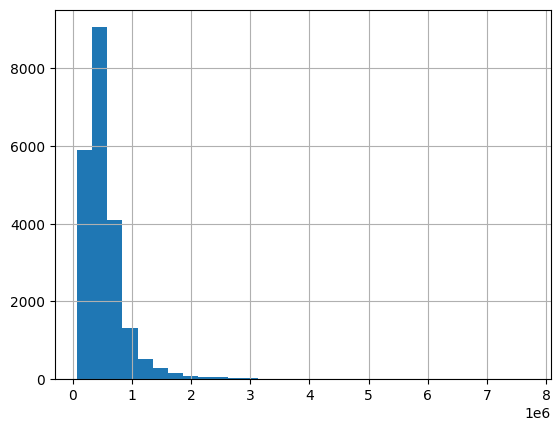

In [4]:
df.price.hist(bins=30)

In [5]:
df['price_log'] = np.log(df.price)

We are going to use a small subset of features for this model, just enough to demonstrate the use case. Along those same lines, we are only going to lightly clean the data (removing outliers that will swamp the loss function).

In [6]:
df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']].describe(percentiles=[x/10 for x in range(10)] + [.95, .99, .999])

,bedrooms,bathrooms,sqft_living,sqft_lot
count,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,3.373200,2.115826,2080.321850,1.509941e+04
std,0.926299,0.768984,918.106125,4.141264e+04
min,1.000000,0.500000,370.000000,5.200000e+02
0%,1.000000,0.500000,370.000000,5.200000e+02
10%,2.000000,1.000000,1090.000000,3.322600e+03
20%,3.000000,1.500000,1320.000000,4.644000e+03
30%,3.000000,1.750000,1520.000000,5.612000e+03
40%,3.000000,2.000000,1710.000000,6.744400e+03
50%,3.000000,2.250000,1910.000000,7.618000e+03


In [7]:
drop_beds = df.bedrooms > 8
drop_bathrooms = df.bathrooms > 5
drop_sqft_living = df.sqft_living > 6000
drop_sqft_lot = df.sqft_lot > 3e+05

In [8]:
mask = drop_beds | drop_bathrooms | drop_sqft_living | drop_sqft_lot

In [9]:
df_clean = df[~mask].copy()

In [10]:
X = df_clean[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']]
y = df_clean.price_log

<Axes: >

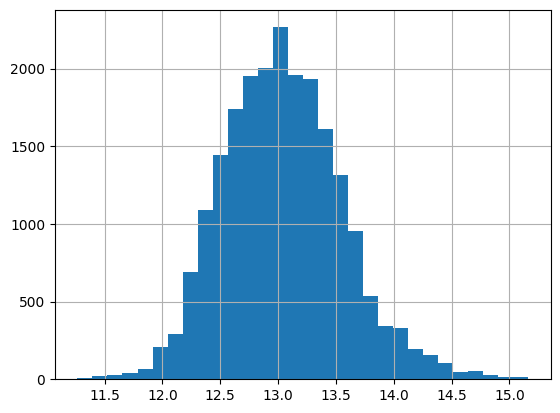

In [11]:
y.hist(bins=30)

In [12]:
regr = OLS(y,X).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                          9.505e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                        0.00
Time:                        06:44:49   Log-Likelihood:                         -54076.
No. Observations:               21437   AIC:                                  1.082e+05
Df Residuals:                   21433   BIC:                                  1.082e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms        2.8086      0.022    129.936      0.000       2.766       2.851
bathrooms       1.8448      0.040     46.038      0.000       1.766       1.923
sqft_living    -0.0006   3.86e-05    -14.523      0.000      -0.001      -0.000
sqft_lot     1.081e-05   8.07e-07     13.384      0.000    9.22e-06    1.24e-05
==============================================================================
Omnibus:                      504.283   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              727.741
Skew:                          -0.263   Prob(JB):                    9.40e-159
Kurtosis:                       3.734   Cond. No.                     5.93e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the residuals plotted against the year built, we can see that there is a pattern; this means that the year built contains information about the price that is not included in the four features selected above. The traditional OLS approach, at this point, would be to group the years into buckets, based on our own knowledge of the housing market and the patterns we see in the residuals. That is a lot of manual work, and we could miss some key interaction. Instead, let's move into the world of neural networks and embeddings.

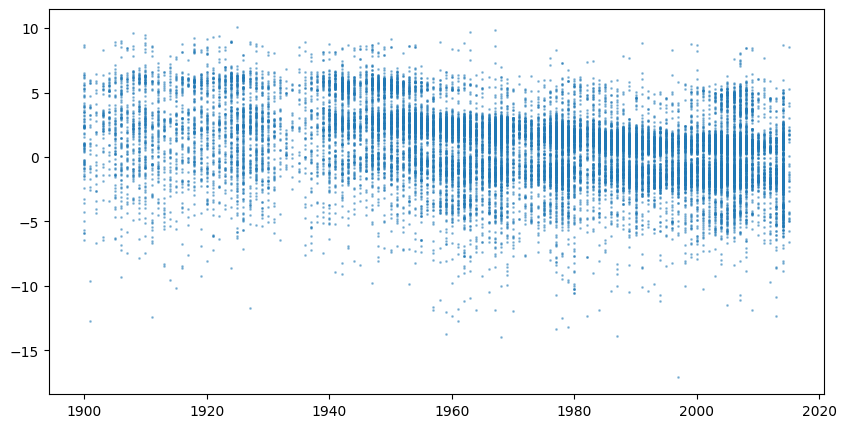

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_clean.yr_built, regr.resid, s=1, alpha=.4)
plt.show()

# Deep Learning
* TODO Add graphic showing the DAG
* TODO Add legend to scatter plot of embedding
* TODO Double check the color matching for the vector embedding
* TODO Allow resampling of data and tran more epochs
* TODO make into movie
* TODO Do the same exercise with Lat/Lon? Would need to introduce mapping software to show the effect
* TODO Highlight that embeddings are an exhaustive mapping from our categories to their vectors. The space between the vectors is not defined

In [12]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import Normalizer

from keras import Model
from keras import ops
from keras import layers
from keras.losses import mean_squared_error
from keras.optimizers import Adam
from keras.regularizers import L1L2, L2
from keras import callbacks

Regression problems are hard for neural networks because the output is not bounded and this can cause the gradient to explode. To limit the risk of an exploding gradient as much as possibile we are going to normalize our input variables by taking the long and then z-scaling.

array([[<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'sqft_living'}>,
        <Axes: title={'center': 'sqft_lot'}>]], dtype=object)

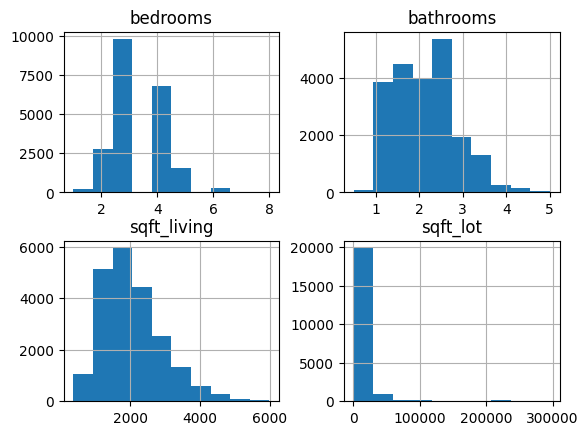

In [13]:
df_clean[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']].hist()

In [14]:
for col in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']:
    df_clean[f'{col}_log'] = np.log(df_clean[col])

array([[<Axes: title={'center': 'bedrooms_log'}>,
        <Axes: title={'center': 'bathrooms_log'}>],
       [<Axes: title={'center': 'sqft_living_log'}>,
        <Axes: title={'center': 'sqft_lot_log'}>]], dtype=object)

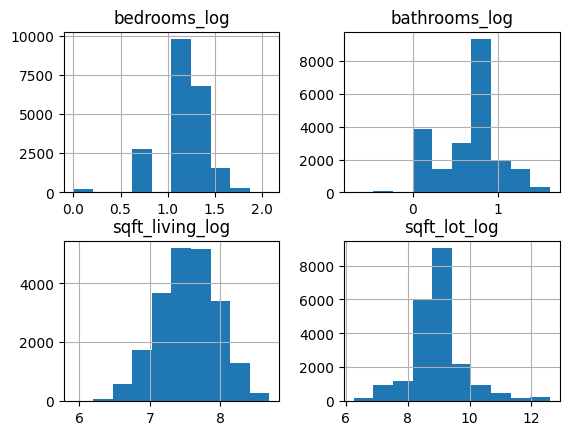

In [15]:
df_clean[['bedrooms_log', 'bathrooms_log', 'sqft_living_log', 'sqft_lot_log']].hist()

In [16]:
def z_scaler(df_in, cols):
    df = df_in.copy()
    
    trans_map = {
        col : {
            'avg': np.average(df[col])
            ,'std': np.std(df[col])
        }
        for col in cols
    }

    for col in cols:
        df[col] = (df[col] - trans_map[col]['avg'])/trans_map[col]['std']
    
    return df, trans_map

In [17]:
df_mod, trans_map = z_scaler(df_clean, ['price_log', 'bedrooms_log', 'bathrooms_log', 'sqft_living_log', 'sqft_lot_log'])

Our variables now all have a mean of zero and a standard deviation of 1.

In [18]:
df_mod[['price_log', 'bedrooms_log', 'bathrooms_log', 'sqft_living_log', 'sqft_lot_log']].describe()

,price_log,bedrooms_log,bathrooms_log,sqft_living_log,sqft_lot_log
count,2.143700e+04,2.143700e+04,2.143700e+04,2.143700e+04,2.143700e+04
mean,-1.519395e-15,-4.096799e-16,1.378858e-16,-4.932069e-16,-1.071267e-15
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-3.432585e+00,-4.186216e+00,-3.516712e+00,-3.910001e+00,-3.131238e+00
25%,-7.054481e-01,-2.748324e-01,-6.895715e-01,-6.865945e-01,-5.161307e-01
50%,-4.680159e-02,-2.748324e-01,3.538418e-01,2.391240e-02,-4.333611e-02
75%,6.336642e-01,7.494005e-01,6.249738e-01,7.071311e-01,3.366043e-01
max,4.100244e+00,3.217209e+00,2.408701e+00,2.763366e+00,4.177505e+00


Year build needs a mapping to integer space index to zero. We'll explain more below when we look at how the embedding layer is updated by backpropegation.

In [19]:
yr_built_map = {v:i for i,v in enumerate(sorted(df.yr_built.unique()))}

In [20]:
df_clean['yr_built_int'] = df_clean.yr_built.map(yr_built_map)

Here, we get to our neural network. This model is as simple as I could reasonably make it. I am using the Keras API (I think it has good readability) with Jax on the backend.

The model follows a simple structure:
* An input layer for our continous variables
* A hidden layer just for the continous variables
* An input layer for our embedding layer
* The embedding layer (We will be embedding our 116 years of home construction into 2 dimensions for easily visualization)
* Flattening the embedding output
* Concatenate the first hidden layer with the output of the embedding
* A second hidden layer
* An output layer

(I am specifying regularization terms for each hidden layer. This is probably overkill, but it is another tool to avoid expoding gradients).

Finally, after each epoch, I will save the embedding layer. After the model is trained, we can look at the embedding layer, epoch by epoch, to watch the topology change.

In [128]:
class CustomCallBack(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = np.array(self.model.layers[1].get_weights()[0])
        np.savetxt(f"./embedding_snap_shot/weights_{epoch}.csv", weights, delimiter=",")

In [129]:
def construct_model(df_cont, yr_built, y):
    input_cat = layers.Input((1,), name="Input Year Embedding")
    emb = layers.Embedding(117, 2, name="Embedding Layer")(input_cat)
    emb = layers.Flatten(name="Flat Embedding")(emb)
    model_emb = Model(input_cat, emb)
    
    input_cont = layers.Input((4,), name="Input Continous Var")
    cont = layers.Dense(
        4
        ,activation = "relu"
        ,kernel_regularizer = L1L2(l1=1e-5, l2=1e-4)
        ,bias_regularizer = L2(1e-4)
        ,activity_regularizer = L2(1e-5)
        ,name = "Hidden Layer - Cont"
    )(input_cont)
    model_cont = Model(input_cont, cont)
    
    combined = layers.concatenate([emb, cont], name="Combined")
    full = layers.Dense(
        8
        ,activation = "relu"
        ,kernel_regularizer = L1L2(l1=1e-5, l2=1e-4)
        ,bias_regularizer = L2(1e-4)
        ,activity_regularizer = L2(1e-5)
        ,name = "Hidden Layer - All"
    )(combined)
    
    full = layers.Dense(1, name="Output Layer")(full)
    
    model = Model(inputs=[input_cont, input_cat], outputs=full, name="embedding_example")
    model.summary()
    
    model.compile(
        loss = mean_squared_error,
        optimizer = Adam(),
        metrics = ["mean_squared_error"]
    )
    
    history = model.fit(
        [df_cont, yr_built]
        ,y
        ,batch_size = 8
        ,epochs = 32
        ,steps_per_epoch = 64
        ,validation_split = 0.2
        ,callbacks = [CustomCallBack()]
    )
    
    return model, history

In [130]:
model, history  = construct_model(
    df_mod[['bedrooms_log', 'bathrooms_log', 'sqft_living_log', 'sqft_lot_log']]
    ,df_clean['yr_built_int']
    ,df_mod.price_log
)

Model: "embedding_example"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Year          │ (None, 1)         │          0 │ -                 │
│ Embedding           │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding Layer     │ (None, 1, 2)      │        234 │ Input Year        │
│ (Embedding)         │                   │            │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input Continous Var │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flat Embedding      │ (None, 2)         │          0 │ Embedding         │
│ (Flatten)           │                   │            │ Layer[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hidden Layer - Cont │ (None, 4)         │         20 │ Input Continous   │
│ (Dense)             │                   │            │ Var[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Combined            │ (None, 6)         │          0 │ Flat              │
│ (Concatenate)       │                   │            │ Embedding[0][0],  │
│                     │                   │            │ Hidden Layer -    │
│                     │                   │            │ Cont[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hidden Layer - All  │ (None, 8)         │         56 │ Combined[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output Layer        │ (None, 1)         │          9 │ Hidden Layer -    │
│ (Dense)             │                   │            │ All[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 319 (1.25 KB)

 Trainable params: 319 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8179 - mean_squared_error: 0.8163 - val_loss: 0.6395 - val_mean_squared_error: 0.6378
Epoch 2/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7081 - mean_squared_error: 0.7065 - val_loss: 0.5832 - val_mean_squared_error: 0.5815
Epoch 3/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5581 - mean_squared_error: 0.5565 - val_loss: 0.5553 - val_mean_squared_error: 0.5536
Epoch 4/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6794 - mean_squared_error: 0.6778 - val_loss: 0.5312 - val_mean_squared_error: 0.5295
Epoch 5/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5449 - mean_squared_error: 0.5433 - val_loss: 0.5238 - val_mean_squared_error: 0.5220
Epoch 6/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5608 - mean_squared_error: 0.5591 - val_loss: 0.5185 - val_mean_squared_error: 0.5168
Epoch 7/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5782 - mean_squared_error: 0.5766 - val_loss: 0.5024 - val_mean

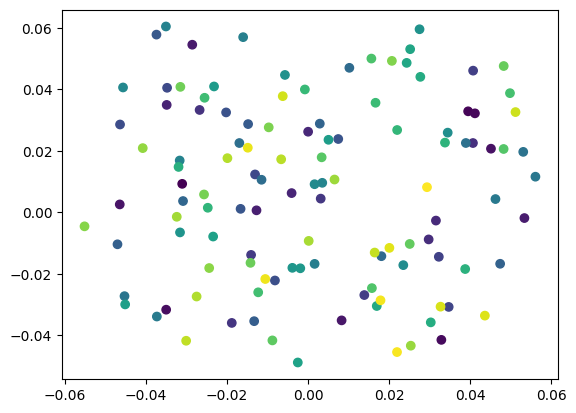

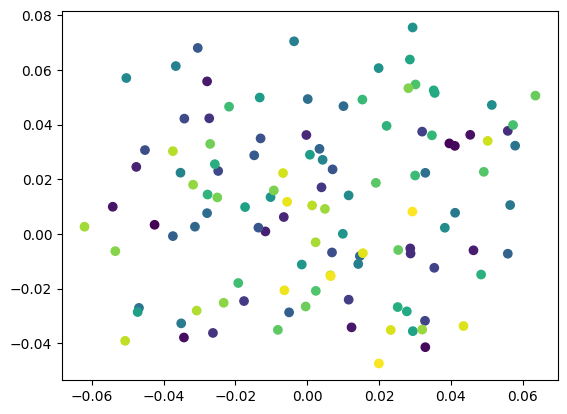

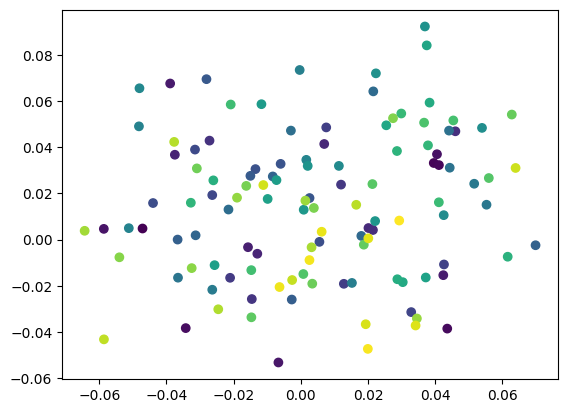

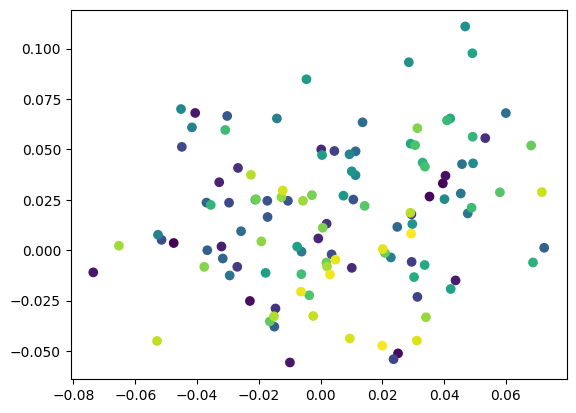

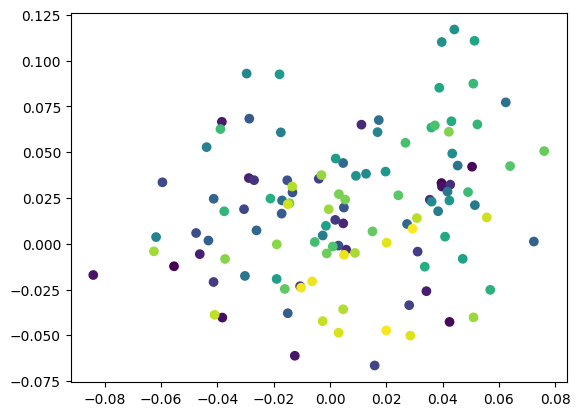

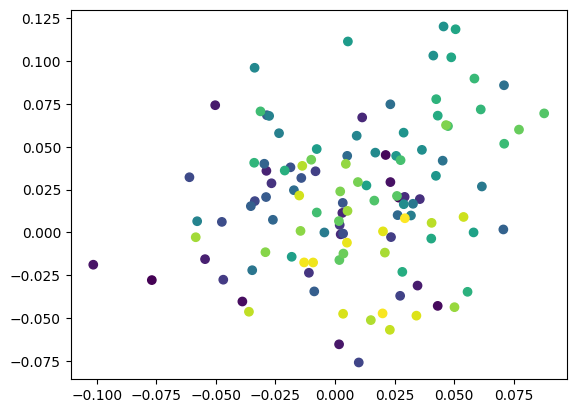

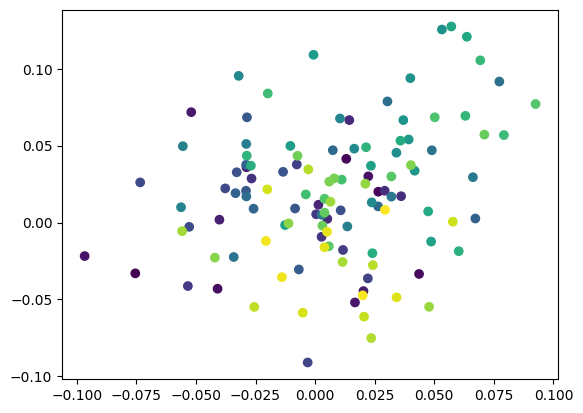

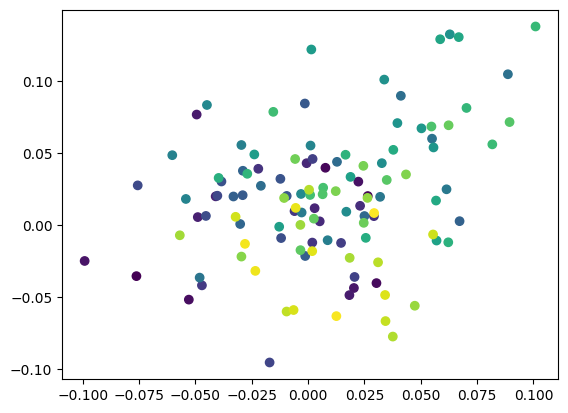

In [132]:
def load_data(epoch):
    weights = np.loadtxt(f"./embedding_snap_shot/weights_{epoch}.csv", delimiter=",")
    return weights[:,0], weights[:,1]

for i in range(8):
    x, y = load_data(i)
    fig, ax = plt.subplots()
    try:
        ax.scatter(x, y, c=np.arange(len(x)))
    except:
        print(i)